In [1]:
import ray
import time
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.dqn.dqn_torch_model import DQNTorchModel
from ray import tune, air
from ray.rllib.core.models.configs import MLPHeadConfig
from ray.rllib.core.models.catalog import Catalog
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.annotations import OverrideToImplementCustomLogic
from gymnasium.spaces import Box, Discrete
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig
import ray.rllib.algorithms.ppo as dqn
from ray.rllib.utils.typing import Dict, TensorType, List, ModelConfigDict
import gymnasium as gym
import matplotlib.pyplot as plt
from ray.rllib.models.torch.misc import SlimFC, AppendBiasLayer
from ray.rllib.policy.torch_policy import TorchPolicy
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.utils.annotations import override
import numpy as np
import pandas as pd
from ray import tune
import math
from torch.distributions.normal import Normal
from ray.tune.schedulers import ASHAScheduler
from ray.tune.registry import register_env
from torch.utils.tensorboard import SummaryWriter
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import os 
import random
import shutil
path = os.getcwd()

In [2]:
torch, nn = try_import_torch()
ray.init()

2024-05-06 20:17:11,760	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67047424 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-06 20:17:12,944	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.9.2


(RolloutWorker pid=3652) /tmp/ipykernel_30945/3677416636.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=3652) /tmp/ipykernel_30945/3677416636.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


In [3]:
class SimpleContextualBandit(gym.Env):
    def __init__(self, config=None):
        self.action_space = Discrete(3)
        self.observation_space = Box(low=-1.0, high = 1.0, shape=(2,))
        self.cur_context = None

    def reset(self, *, seed = None, options = None):
        self.cur_context = random.choice([-1.0, 1.0])
        return np.array([self.cur_context, -self.cur_context]), {}

    def step(self, action):
        rewards_for_context = {
            -1.0: [-10, 0, 10],
            1.0: [10, 0, -10],
        }
        reward = rewards_for_context[self.cur_context][action]
        return (
            np.array([-self.cur_context, self.cur_context]),
            reward,
            True,
            False,
            {'regret': 10 - reward},
        )

register_env('SimpleContextualBandit', SimpleContextualBandit)

In [4]:
class BernoulliBandit(gym.Env):
    def __init__(self, config=None):
        self.action_space = Discrete(5)
        self.observation_space = Box(low=0.0, high = 1.0)
        self.num_actions = 5
        self.last_action_reward = None

    def reset(self, *, seed = None, options = None):
        self.last_action_reward = random.choice([0,1])
        return np.array([0]), {}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action selection"
        if action < self.num_actions - 1:
            reward = np.random.binomial(1,0.5)
        else:
            reward = self.last_action_reward

        print(f'regret: {1 - reward if action < self.num_actions - 1 else 1 - self.last_action_reward}')

        return (
            np.array([0]), 
            reward, 
            True, 
            False,
            {'regret': 1 - reward if action < self.num_actions - 1 else 1 - self.last_action_reward},
        )

register_env('BernoulliBandit', BernoulliBandit)

In [5]:
class ENNDQNModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(ENNDQNModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        nn.Module.__init__(self)
        #gpu nonsense
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        hidden_layer0 = model_config['fcnet_hiddens'][0]
        hidden_layer1 = model_config['fcnet_hiddens'][1]
        enn_layer = 15

        #object instance variables
        self.z_dim = 5
        self.mean = 0.0
        self.std = 1.0
        self.step_number = 0
        self.z_indices = None
        self.gamma = 0.99
        self.initializer = torch.nn.init.xavier_normal_
        self.activation_fn = model_config['fcnet_activation']
        self.num_atoms = 1

        self.distribution = Normal(torch.full((self.z_dim,), self.mean), torch.full((self.z_dim,), self.std))

        self.action_space_size = 4
        self.map_size = 8
        
        self.action_space = action_space
        self.q_network = TorchFC(obs_space, action_space, self.action_space_size*self.num_atoms, model_config, name + "_q_testing")
        
        self.qnetwork_in = SlimFC(obs_space.shape[0], hidden_layer0, initializer=self.initializer, activation_fn=self.activation_fn)
        self.qnetwork_1 = SlimFC(hidden_layer0, hidden_layer1, initializer=self.initializer, activation_fn=self.activation_fn)
        self.qnetwork_out = SlimFC(hidden_layer1, self.action_space_size*self.num_atoms, initializer=self.initializer, activation_fn=self.activation_fn)
        
        self.enn_learnable_in = SlimFC(hidden_layer1 + 1, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn)
        self.enn_learnable_1 = SlimFC(enn_layer, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn)
        self.enn_learnable_out = SlimFC(enn_layer, self.action_space_size*self.num_atoms, initializer=self.initializer, activation_fn=None)

        self.prior_in = SlimFC(hidden_layer1 + 1, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn)
        self.prior_1 = SlimFC(enn_layer, enn_layer, initializer=self.initializer, activation_fn=self.activation_fn)
        self.prior_out = SlimFC(enn_layer, self.action_space_size*self.num_atoms, initializer=self.initializer, activation_fn=None)
        

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):

        obs = input_dict["obs_flat"].float()
        action_logits, _ = self.q_network(input_dict, state, seq_lens)

        batch_size = obs.shape[0]

        base_in = self.qnetwork_in(obs)
        base_1 = self.qnetwork_1(base_in).to(self.device)
        self.base_1_detached = torch.unsqueeze(base_1, 1).detach()
        base_out = self.qnetwork_out(base_1)
        self.base_value, self.base_indice = torch.max(base_out, dim=-1, keepdim=True)

        self.z_indices = self.distribution.sample((batch_size,)).to(self.device)
        self.z_unsqueeze = torch.unsqueeze(self.z_indices, -1)
        enn_input = torch.cat((self.z_unsqueeze, self.base_1_detached.expand(-1, self.z_dim, -1)), dim=2)
        # batch_size, hidden_layer + 1, z_dimensions

        if self.step_number < 200:
            #prior value (learnable)
            prior_in = self.prior_in(enn_input)
            prior_1 = self.prior_1(prior_in)
            prior = self.prior_out(prior_1)
        else:
            with torch.no_grad():
                #prior value (static)
                prior_in = self.prior_in(enn_input)
                prior_1 = self.prior_1(prior_in)
                prior = self.prior_out(prior_1)
        
        # learnable on features and z concat
        learnable_in = self.enn_learnable_in(enn_input)
        learnable_1 = self.enn_learnable_1(learnable_in)
        learnable = self.enn_learnable_out(learnable_1)
        learnable_bmm = torch.bmm(torch.transpose(learnable, 1, 2), self.z_unsqueeze)
        learnable_out = learnable_bmm.squeeze(-1)
        #the above returns (batch_size, num_actions)
        #so we select the 'max action' and return the value / index
        self.learnable_value = torch.gather(learnable_out, 1, self.base_indice)

        # prior on features and z concat
        prior_bmm = torch.bmm(torch.transpose(prior, 1, 2), self.z_unsqueeze)
        prior_output = prior_bmm.squeeze(-1)
        self.prior_value = torch.gather(prior_output, 1, self.base_indice)

        self.action_values = base_out + learnable_out + prior_output

        self.step_number += 1
            
        return self.action_values, state
        
    @override(TorchModelV2)
    def value_function(self):
        #this should be the argmax values added together
        return self.learnable_value + self.prior_value + self.base_value


    @override(TorchModelV2)
    def custom_loss(self, policy_loss, sample_batch):
        cur_obs = sample_batch[SampleBatch.CUR_OBS]
        next_obs = sample_batch[SampleBatch.NEXT_OBS]
        rewards = sample_batch[SampleBatch.REWARDS]
        dones = sample_batch[SampleBatch.DONES]


        #target critic value
        next_base_in = self.qnetwork_in(next_obs)
        next_base_1 = self.qnetwork_1(next_base_in)
        next_base_1_detached = torch.unsqueeze(next_base_1, 1).detach()
        next_base_out = self.qnetwork_out(next_base_1)
        next_base_value, next_base_indice = torch.max(next_base_out, dim=-1, keepdim=True)

        #enn target value
        next_enn_input = torch.cat((self.z_unsqueeze, next_base_1_detached.expand(-1, self.z_dim, -1)), dim=2)
        next_learnable_in = self.enn_learnable_in(next_enn_input)
        next_learnable_1 = self.enn_learnable_1(next_learnable_in)
        next_learnable = self.enn_learnable_out(next_learnable_1)
        next_learnable_bmm = torch.bmm(torch.transpose(next_learnable, 1, 2), self.z_unsqueeze)
        next_learnable_out = next_learnable_bmm.squeeze(-1)
        next_learnable_value = torch.gather(next_learnable_out, 1, self.base_indice)

        #with current setup - one iteration is 480 step numbers
        if self.step_number < 200:
            #prior target value (learnable)
            next_prior_in = self.prior_in(next_enn_input)
            next_prior_1 = self.prior_1(next_prior_in)
            next_prior = self.prior_out(next_prior_1)
        else:
            with torch.no_grad():
                #prior target value (static)
                next_prior_in = self.prior_in(next_enn_input)
                next_prior_1 = self.prior_1(next_prior_in)
                next_prior = self.prior_out(next_prior_1)

        next_prior_bmm = torch.bmm(torch.transpose(next_prior, 1, 2), self.z_unsqueeze)
        next_prior_out = next_prior_bmm.squeeze(-1)
        next_prior_value = torch.gather(next_prior_out, 1, self.base_indice)
        
        #enn total (enn = prior(critic_features, z) + enn_learnable(critic_features, z))
        enn_out = self.learnable_value + self.prior_value
        next_enn_out = next_learnable_value + next_prior_value
        #td loss for enn network minus the base network
        enn_target = rewards + self.gamma * next_enn_out.detach() * (1 - dones.float())
        enn_loss_square = torch.square(enn_out - enn_target)
        enn_loss = torch.mean(enn_loss_square)
        #detach target from being udpated / base network TD loss
        # base_target = rewards + self.gamma * next_base_value.detach() * (1 - dones.float())
        # base_square = torch.square(self.base_value - base_target)
        # base_loss = torch.mean(base_square)

        # l2_lambda = self.lambda_coeff / max(1, self.total_data_seen)

        # l2_reg = torch.tensor(0., device=self.device)
        # for name, param in self.named_parameters():
        #     if 'prior' or 'enn' in name:
        #         l2_reg += torch.norm(param)
        # l2_loss = l2_lambda * l2_reg

        total_loss = [loss + enn_loss for loss in policy_loss]

        return total_loss



ModelCatalog.register_custom_model("ENNDQNModel", ENNDQNModel)

In [6]:
gym.make('FrozenLake-v1', is_slippery=True, map_name='4x4')

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [7]:
%%time
config = DQNConfig().training(
    num_atoms = 1,
    v_min = -10.0,
    v_max = 10.0,
    noisy = False,
    # sigma0 = 0.5,
    #sets initial weights for noisy nets
    dueling = False,
    double_q = False,
    n_step = 1, 
    hiddens = (),
    target_network_update_freq = 10,
    num_steps_sampled_before_learning_starts = 20,
    replay_buffer_config = {
        'capacity': 1000
    },
    #IMPORTANT: need hiddens = [] and dueling = False for parametric action spaces
    before_learn_on_batch = None,
    training_intensity = None,
    td_error_loss_fn = 'huber',
    lr = 0.0003,
    #td error loss is ignored if num_atoms > 1
    categorical_distribution_temperature = 1.0,
    optimizer = {
        'weight_decay': 0.01
    },
    #temperature in the range of [0,1] which affects evaluation
    model={
        'custom_model': 'ENNDQNModel',
        'no_final_linear': False,
        'fcnet_hiddens': [64,64],
        'fcnet_activation': 'relu',
        'vf_share_layers': False
    }
).environment(
    env='FrozenLake-v1',
).rollouts(
    num_rollout_workers = 28,
).resources(
    num_gpus = 1
)

algo = config.build()

num_iterations = 500
rewards = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    
ray.shutdown()

2024-05-06 20:17:14,364	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, 

Iteration: 0, Mean Reward: 0.018867924528301886
Iteration: 1, Mean Reward: 0.015384615384615385
Iteration: 2, Mean Reward: 0.015503875968992248
Iteration: 3, Mean Reward: 0.023809523809523808
Iteration: 4, Mean Reward: 0.023076923076923078
Iteration: 5, Mean Reward: 0.019417475728155338
Iteration: 6, Mean Reward: 0.06
Iteration: 7, Mean Reward: 0.04950495049504951
Iteration: 8, Mean Reward: 0.009900990099009901
Iteration: 9, Mean Reward: 0.02
Iteration: 10, Mean Reward: 0.08
Iteration: 11, Mean Reward: 0.09
Iteration: 12, Mean Reward: 0.07
Iteration: 13, Mean Reward: 0.14
Iteration: 14, Mean Reward: 0.18
Iteration: 15, Mean Reward: 0.15
Iteration: 16, Mean Reward: 0.14
Iteration: 17, Mean Reward: 0.2
Iteration: 18, Mean Reward: 0.2
Iteration: 19, Mean Reward: 0.26
Iteration: 20, Mean Reward: 0.22
Iteration: 21, Mean Reward: 0.21
Iteration: 22, Mean Reward: 0.19
Iteration: 23, Mean Reward: 0.18
Iteration: 24, Mean Reward: 0.21
Iteration: 25, Mean Reward: 0.24
Iteration: 26, Mean Reward:

(RolloutWorker pid=3981) /tmp/ipykernel_30945/3677416636.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead. [repeated 54x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


CPU times: user 20min 30s, sys: 1min 20s, total: 21min 51s
Wall time: 19min 25s


In [8]:
DQN_ENN_2 = pd.DataFrame(rewards)

In [9]:
DQN_ENN_2.to_csv(path + '/DQN_results/DQN_ENN_2.csv')

In [10]:
DQN_vanilla_4x4 = pd.read_csv(f'/mnt/work/home/tyler/reinforcement_learning/epinet_testing/DQN_results/DQN_vanilla_4x4.csv')
DQN_C51 = pd.read_csv(f'/mnt/work/home/tyler/reinforcement_learning/epinet_testing/DQN_results/DQN_C51.csv')
DQN_ENN = pd.read_csv(f'/mnt/work/home/tyler/reinforcement_learning/epinet_testing/DQN_results/DQN_ENN.csv')
DQN_ENN_2 = pd.read_csv(f'/mnt/work/home/tyler/reinforcement_learning/epinet_testing/DQN_results/DQN_ENN_2.csv')

In [11]:
summed_4x4 = np.cumsum(DQN_vanilla_4x4['0'])
summed_C51 = np.cumsum(DQN_C51['0'])
summed_ENN = np.cumsum(DQN_ENN['0'])
summed_ENN_2 = np.cumsum(DQN_ENN_2['0'])
# summed_4x4 = np.cumsum(DQN_vanilla_4x4['0'])

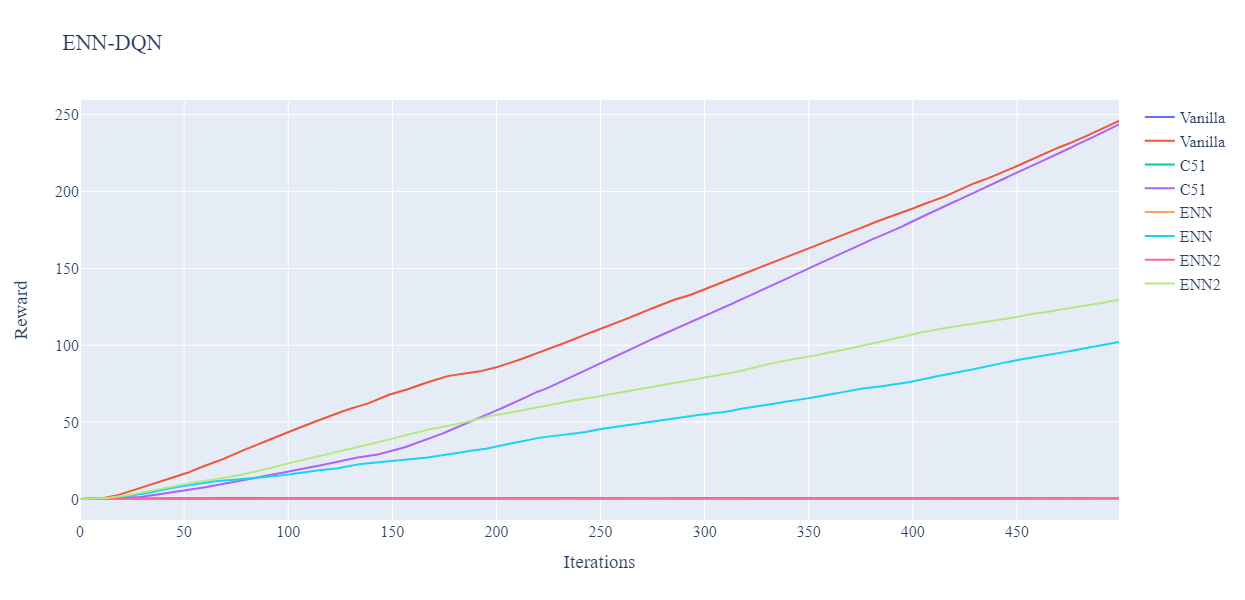

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = DQN_vanilla_4x4['0'], mode = 'lines', name = 'Vanilla'))
fig.add_trace(go.Scatter(y = summed_4x4, mode = 'lines', name = 'Vanilla'))
fig.add_trace(go.Scatter(y = DQN_C51['0'], mode = 'lines', name = 'C51'))
fig.add_trace(go.Scatter(y = summed_C51, mode = 'lines', name = 'C51'))
fig.add_trace(go.Scatter(y = DQN_ENN['0'], mode = 'lines', name = 'ENN'))
fig.add_trace(go.Scatter(y = summed_ENN, mode = 'lines', name = 'ENN'))
fig.add_trace(go.Scatter(y = DQN_ENN_2['0'], mode = 'lines', name = 'ENN2'))
fig.add_trace(go.Scatter(y = summed_ENN_2, mode = 'lines', name = 'ENN2'))

fig.update_layout(title_text="ENN-DQN", xaxis_title = 'Iterations', yaxis_title = 'Reward',
                 font = dict(
                     family = 'Times New Roman',
                     size = 16
                 ),
                 width = 1_000,
                 height = 600,
                 showlegend = True,
                 )
# fig.write_image('/loss_function_comparison.png')
fig.show()